# Transport equation with source term

$$
\renewcommand{\DdQq}[2]{{\mathrm D}_{#1}{\mathrm Q}_{#2}}
\renewcommand{\drondt}{\partial_t}
\renewcommand{\drondx}{\partial_x}
\renewcommand{\dx}{\Delta x}
\renewcommand{\dt}{\Delta t}
\renewcommand{\grandO}{{\mathcal O}}
\renewcommand{\density}[2]{\,f_{#1}^{#2}}
\renewcommand{\fk}[1]{\density{#1}{\vphantom{\star}}}
\renewcommand{\fks}[1]{\density{#1}{\star}}
\renewcommand{\moment}[2]{\,m_{#1}^{#2}}
\renewcommand{\mk}[1]{\moment{#1}{\vphantom{\star}}}
\renewcommand{\mke}[1]{\moment{#1}{e}}
\renewcommand{\mks}[1]{\moment{#1}{\star}}
$$

In this tutorial, we propose to add a source term in the advection equation. The problem reads
$$\drondt u + c \drondx u = S(t, x, u), \quad t>0, , \quad x\in(0, 1),$$

where $c$ is a constant scalar (typically $c=1$).
Additional boundary and initial conditions will be given in the following.
$S$ is the source term that can depend on the time $t$, the space $x$ and the solution $u$.

In order to simulate this problem, we use the $\DdQq{1}{2}$ scheme and we add an additional `key:value` in the dictionary for the source term. We deal with two examples.

## A friction term

In this example, we takes $S(t, x, u) = -\alpha u$ where $\alpha$ is a positive constant. 
The dictionary of the simulation then reads:

In [1]:
from __future__ import print_function, division
%matplotlib inline
import sympy as sp
import numpy as np
import pylbm

/home/loic/miniconda3/envs/pylbm/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


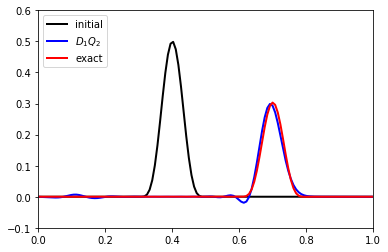

In [2]:
C, ALPHA, X, u, LA = sp.symbols('C, ALPHA, X, u, LA')
c = 0.3
alpha = 0.5

def init(x):
    middle, width, height = 0.4, 0.1, 0.5   
    return height/width**10 * (x%1-middle-width)**5 * \
                              (middle-x%1-width)**5 * (abs(x%1-middle)<=width)
    
def solution(t, x):
    return init(x - c*t)*np.exp(-alpha*t)

dico = {
    'box':{'x':[0., 1.], 'label':-1},
    'space_step':1./128,
    'scheme_velocity':LA,
    'schemes':[
        {
            'velocities':[1,2],
            'conserved_moments':u,
            'polynomials':[1,LA*X],
            'relaxation_parameters':[0., 2.],
            'equilibrium':[u, C*u],
            'source_terms':{u:-ALPHA*u},
            'init':{u:(init,)},
        },
    ],
    'parameters': {LA: 1., C: c, ALPHA: alpha},
    'generator': 'numpy',
}

sol = pylbm.Simulation(dico) # build the simulation
viewer = pylbm.viewer.matplotlibViewer
fig = viewer.Fig()
ax = fig[0]
ax.axis(0., 1., -.1, .6)
x = sol.domain.x
ax.plot(x, sol.m[u], width=2, color='k', label='initial')
while sol.t < 1:
    sol.one_time_step()
ax.plot(x, sol.m[u], width=2, color='b', label=r'$D_1Q_2$')
ax.plot(x, solution(sol.t, x), width=2, color='r', label='exact')
ax.legend()

## A source term depending on time and space

If the source term $S$ depends explicitely on the time or on the space, we have to specify the corresponding variables in the dictionary through the key *parameters*. The time variable is prescribed by the key *'time'*. Moreover, sympy functions can be used to define the source term like in the following example. This example is just for testing the feature... no physical meaning in mind !

In [ ]:
t, C, X, u, LA = sp.symbols('t, C, X, u, LA')
c = 0.3

def init(x):
    middle, width, height = 0.4, 0.1, 0.5   
    return height/width**10 * (x%1-middle-width)**5 * \
                              (middle-x%1-width)**5 * (abs(x%1-middle)<=width)
    
dico = {
    'box':{'x':[0., 1.], 'label':-1},
    'space_step':1./128,
    'scheme_velocity':LA,
    'schemes':[
        {
            'velocities':[1,2],
            'conserved_moments':u,
            'polynomials':[1,LA*X],
            'relaxation_parameters':[0., 2.],
            'equilibrium':[u, C*u],
            'source_terms':{u:-sp.Abs(X-t)**2*u},
            'init':{u:(init,)},
        },
    ],
    'generator': 'cython',
    'parameters': {LA: 1., C: c, 'time': t},
}

sol = pylbm.Simulation(dico) # build the simulation
viewer = pylbm.viewer.matplotlibViewer
fig = viewer.Fig()
ax = fig[0]
ax.axis(0., 1., -.1, .6)
x = sol.domain.x
ax.plot(x, sol.m[u], width=2, color='k', label='initial')
while sol.t < 1:
    sol.one_time_step()
ax.plot(x, sol.m[u], width=2, color='b', label=r'$D_1Q_2$')
ax.legend()